In [2]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from tqdm import trange
import os
import datetime
import time

In [3]:
sentiment_file = 'song_sentiment.csv'
no1_file = 'weekly_no1s.csv'
start_frame = '2005-01-01'
# end_frame = '2005-06-01'
end_frame = '2015-01-01'

In [21]:
no1_df = pd.read_csv(no1_file)
no1_df['SongID'] = no1_df['SongID'].map(lambda x: str(x).upper())
no1_df.head(5)

,WeekID,Week Position,Song,Performer,SongID
0,1958-08-02,1,Poor Little Fool,Ricky Nelson,POOR LITTLE FOOLRICKY NELSON
1,1958-08-09,1,Poor Little Fool,Ricky Nelson,POOR LITTLE FOOLRICKY NELSON
2,1958-08-16,1,Nel Blu Dipinto Di Blu (Volar├®),Domenico Modugno,NEL BLU DIPINTO DI BLU (VOLAR├®)DOMENICO MODUGNO
3,1958-08-23,1,Little Star,The Elegants,LITTLE STARTHE ELEGANTS
4,1958-08-30,1,Nel Blu Dipinto Di Blu (Volar├®),Domenico Modugno,NEL BLU DIPINTO DI BLU (VOLAR├®)DOMENICO MODUGNO


In [22]:
sent_df = pd.read_csv(sentiment_file)


sent_df['SongID'] = sent_df['title'].astype('str') + sent_df['artist'].astype('str')
sent_df['SongID'] = sent_df['SongID'].map(lambda x: str(x).upper())
sent_df.head(5)

,artist,title,year,pos,neg,lyrics,SongID
0,Nat King Cole,Mona Lisa,1950,0.199,0.155,"Mona Lisa, Mona Lisa, men have named you\nYou'...",MONA LISANAT KING COLE
1,Andrews Sisters,I Wanna Be Loved,1950,0.224,0.036,I wanna be Loved\nBy Andrews Sisters\n\nOooo-o...,I WANNA BE LOVEDANDREWS SISTERS
2,Patti Page,Tennessee Waltz,1950,0.351,0.053,I was dancing with my darling to the Tennessee...,TENNESSEE WALTZPATTI PAGE
3,Tennessee Ernie Ford,I'll Never Be Free,1950,0.231,0.167,Each time I hold someone new\nMy arms grow col...,I'LL NEVER BE FREETENNESSEE ERNIE FORD
4,Patti Page,All My Love,1950,0.079,0.070,"Unfortunately, we are not licensed to display ...",ALL MY LOVEPATTI PAGE


In [6]:
df = no1_df[(no1_df.WeekID > start_frame) & (no1_df.WeekID < end_frame)].copy()
map_id ={'CHECK ON ITBEYONCE FEATURING SLIM THUG':'CHECK ON ITBEYONCE',
         'PROMISCUOUSNELLY FURTADO FEATURING TIMBALAND':'PROMISCUOUSNELLY FURTADO',
         'SEXYBACKJUSTIN TIMBERLAKE':'SEXYBACKJUSTIN TIMBERLAKE',
         'UMBRELLARIHANNA FEATURING JAY-Z':'UMBRELLARIHANNA',
         "RIDIN'CHAMILLIONAIRE FEATURING KRAYZIE BONE" : "RIDIN'CHAMILLIONAIRE",
         "MY LOVEJUSTIN TIMBERLAKE FEATURING T.I.":"MY LOVEJUSTIN TIMBERLAKE",
         "MONEY MAKERLUDACRIS FEATURING PHARRELL":"MONEY MAKERLUDACRIS",
         'HOLLABACK GIRLGWEN STEFANI':'HOLLABACK GIRLGWEN STEFANI',
         "I WANNA LOVE YOUAKON FEATURING SNOOP DOGG":"I WANNA LOVE YOUAKON",
         "GLAMOROUSFERGIE FEATURING LUDACRIS":"GLAMOROUSFERGIE",
         'WHAT GOES AROUND...COMES AROUNDJUSTIN TIMBERLAKE':"WHAT GOES AROUND COMES AROUNDJUSTIN TIMBERLAKE",
         "LOWFLO RIDA FEATURING T-PAIN":"LOWFLO RIDA",
         "DO I MAKE YOU PROUDTAYLOR HICKS":"DO I MAKE YOU PROUDTAYLOR HICKS",
         "GIVE IT TO METIMBALAND FEATURING NELLY FURTADO & JUSTIN TIMBERLAKE":"GIVE IT TO METIMBALAND",
         "CANDY SHOP50 CENT FEATURING OLIVIA":"CANDY SHOP50 CENT",
         "TIMBERPITBULL FEATURING KE$HA":"TIMBERPITBULL",
         "SHAKE IT OFFTAYLOR SWIFT":"SHAKE IT OFFTAYLOR SWIFT",
         "FANCYIGGY AZALEA FEATURING CHARLI XCX":"FANCYIGGY AZALEA",
         "BLURRED LINESROBIN THICKE FEATURING T.I. + PHARRELL":'BLURRED LINESROBIN THICKE',
         "CAN'T HOLD USMACKLEMORE & RYAN LEWIS FEATURING RAY DALTON":"CAN'T HOLD USMACKLEMORE",
         "THE MONSTEREMINEM FEATURING RIHANNA":"THE MONSTEREMINEM",
         "DARK HORSEKATY PERRY FEATURING JUICY J" : "DARK HORSEKATY PERRY",
         "THRIFT SHOPMACKLEMORE & RYAN LEWIS FEATURING WANZ" : "THRIFT SHOPMACKLEMORE",
         "SOMEBODY THAT I USED TO KNOWGOTYE FEATURING KIMBRA" : "SOMEBODY THAT I USED TO KNOWGOTYE",
         "STRONGER (WHAT DOESN'T KILL YOU)KELLY CLARKSON" : "STRONGERKELLY CLARKSON",
         "WE FOUND LOVERIHANNA FEATURING CALVIN HARRIS" : "WE FOUND LOVERIHANNA",
         "JUST GIVE ME A REASONP!NK FEATURING NATE RUESS":"JUST GIVE ME A REASONP!NK",
         "SINGLE LADIES (PUT A RING ON IT)BEYONCE":"SINGLE LADIESBEYONCE",
         "BOOM BOOM POWTHE BLACK EYED PEAS":"BOOM BOOM POWBLACK EYED PEAS",
         "I GOTTA FEELINGTHE BLACK EYED PEAS" : "I GOTTA FEELINGBLACK EYED PEAS",
         "EMPIRE STATE OF MINDJAY-Z + ALICIA KEYS" : "EMPIRE STATE OF MINDJAY-Z",
         "CALIFORNIA GURLSKATY PERRY FEATURING SNOOP DOGG" : "CALIFORNIA GURLSKATY PERRY",
         "LOVE THE WAY YOU LIEEMINEM FEATURING RIHANNA" : "LOVE THE WAY YOU LIEEMINEM",
         "OMGUSHER FEATURING WILL.I.AM" : "OMGUSHER",
         "PARTY ROCK ANTHEMLMFAO FEATURING LAUREN BENNETT & GOONROCK" : "PARTY ROCK ANTHEMLMFAO",
         "E.T.KATY PERRY FEATURING KANYE WEST" : "E.T.KATY PERRY",
         "LOVE IN THIS CLUBUSHER FEATURING YOUNG JEEZY":"LOVE IN THIS CLUBUSHER"
        }

for k,v in map_id.items():
    df.loc[df['SongID'] == k, 'SongID'] = v

df['pos'] = np.NaN
df['neg'] = np.NaN

In [7]:
for index, row in df.iterrows():
    if (sent_df[sent_df.SongID == row.SongID]['pos'].values).size > 0:

        try:
            df.loc[index, 'pos'] = sent_df[sent_df.SongID == row.SongID]['pos'].values
            df.loc[index, 'neg'] = sent_df[sent_df.SongID == row.SongID]['neg'].values
        except:

            df.loc[index, 'pos'] = (sent_df[sent_df.SongID == row.SongID]['pos'].values)[0]
            df.loc[index, 'neg'] = (sent_df[sent_df.SongID == row.SongID]['neg'].values)[0]
df[df.pos.isnull()]

,WeekID,Week Position,Song,Performer,SongID,pos,neg
2423,2005-01-08,1,Let Me Love You,Mario,LET ME LOVE YOUMARIO,NaN,NaN
2424,2005-01-15,1,Let Me Love You,Mario,LET ME LOVE YOUMARIO,NaN,NaN
2425,2005-01-22,1,Let Me Love You,Mario,LET ME LOVE YOUMARIO,NaN,NaN
2426,2005-01-29,1,Let Me Love You,Mario,LET ME LOVE YOUMARIO,NaN,NaN
2427,2005-02-05,1,Let Me Love You,Mario,LET ME LOVE YOUMARIO,NaN,NaN
...,...,...,...,...,...,...,...
2922,2014-08-02,1,Rude,MAGIC!,RUDEMAGIC!,NaN,NaN
2923,2014-08-09,1,Rude,MAGIC!,RUDEMAGIC!,NaN,NaN
2924,2014-08-16,1,Rude,MAGIC!,RUDEMAGIC!,NaN,NaN
2925,2014-08-23,1,Rude,MAGIC!,RUDEMAGIC!,NaN,NaN


In [8]:
df[df['pos'].isnull()]['WeekID'].count() / df['WeekID'].count()

0.19577735124760076

In [9]:
sent_df[sent_df['SongID'].str.contains('CLUBUSHER')]['SongID']
no1_df[no1_df['SongID'].str.contains('CLUBUSHER')]['SongID'].values

array(['LOVE IN THIS CLUBUSHER FEATURING YOUNG JEEZY',
       'LOVE IN THIS CLUBUSHER FEATURING YOUNG JEEZY',
       'LOVE IN THIS CLUBUSHER FEATURING YOUNG JEEZY'], dtype=object)

In [10]:
filled_df = df.fillna(method='bfill').copy()
filled_df[filled_df['pos'].isnull()]

,WeekID,Week Position,Song,Performer,SongID,pos,neg


In [13]:
weekly_sent = filled_df[['WeekID','pos','neg']].copy()

weekly_sent['net_sent'] = weekly_sent['pos'] - weekly_sent['neg']

weekly_sent['net_sent'] = weekly_sent['net_sent']- weekly_sent['net_sent'].mean()

In [16]:
weekly_sent['net_sent'].mean()

6.8190281742811916e-18

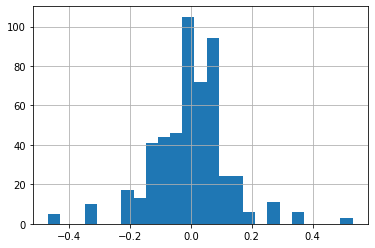

In [20]:
weekly_sent['net_sent'].hist(bins =25)

In [15]:
weekly_sent.to_csv(index=False, path_or_buf = 'weekly_sentiment.csv')